In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'supermarket-sales:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F205965%2F451952%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240318%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240318T042856Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da6c04143ef383b7f83338cbe4bb5fb4c0285937437e6b0ba23dfd7b257dfb431ed1081e550c37702d664461d727f0d98c795a2972b55abb8e0889d060f920c86b6fd993808a8162d8b0891ac8772631285ee2cf83e9fabb1ed271bbed669d9f10c022b3c4f9ca4ab10fe763acdeb0a369834f68e572fbcfa85be972171602a01873abb8130fbb53febd83c4f930c93027e586d59f400646da0de8f2c4b29116c6e30b33a866bd8fad47d89bf3d2a3593d1966e7c378c455eb43c50d3da6ef92878225e75ccd2e12d10be24ca7c68e6acbf5fe522bca5792bbe99ae4284b307f640e12440f6801b717e602ea9ca0d872424b9d959a70e3f2699a4e2ff9d15861b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 36801 bytes downloaded
Downloaded and uncompressed: supermarket-sales
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/kaggle/input/supermarket-sales/supermarket_sales - Sheet1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

In [ ]:
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [ ]:
def extract_timeofday(x):
    if x == 00:
        return 'Midnight'
    elif x == 12:
        return "Noon"
    elif x > 00 and x < 12:
        return "Morning"
    elif x > 12 and x < 18:
        return "Afternoon"
    else:
        return "Evening"

In [ ]:
df['Day time'] = pd.to_datetime(df['Time']).dt.hour.apply(extract_timeofday)

In [ ]:
df.drop(['Invoice ID', 'Time'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
for i in df.columns[df.dtypes == 'object']:
    print(df[i].value_counts(dropna=False))
    print()

A    340
B    332
C    328
Name: Branch, dtype: int64

Yangon       340
Mandalay     332
Naypyitaw    328
Name: City, dtype: int64

Member    501
Normal    499
Name: Customer type, dtype: int64

Female    501
Male      499
Name: Gender, dtype: int64

Fashion accessories       178
Food and beverages        174
Electronic accessories    170
Sports and travel         166
Home and lifestyle        160
Health and beauty         152
Name: Product line, dtype: int64

Ewallet        345
Cash           344
Credit card    311
Name: Payment, dtype: int64

Afternoon    439
Evening      281
Morning      191
Noon          89
Name: Day time, dtype: int64



In [ ]:
df.duplicated().any()

False

In [ ]:
df.isna().sum()

Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Date                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
Day time                   0
dtype: int64

In [ ]:
df.head()

,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Payment,cogs,gross margin percentage,gross income,Rating,Day time
0,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,Ewallet,522.83,4.761905,26.1415,9.1,Afternoon
1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,Cash,76.40,4.761905,3.8200,9.6,Morning
2,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,Credit card,324.31,4.761905,16.2155,7.4,Afternoon
3,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,Ewallet,465.76,4.761905,23.2880,8.4,Evening
4,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,Ewallet,604.17,4.761905,30.2085,5.3,Morning


In [ ]:
categorical = df.select_dtypes(include = 'object').columns
numerical = df.select_dtypes(include = 'number').columns

In [ ]:
plt.style.use('fivethirtyeight')
palette = sns.color_palette('deep', 8)

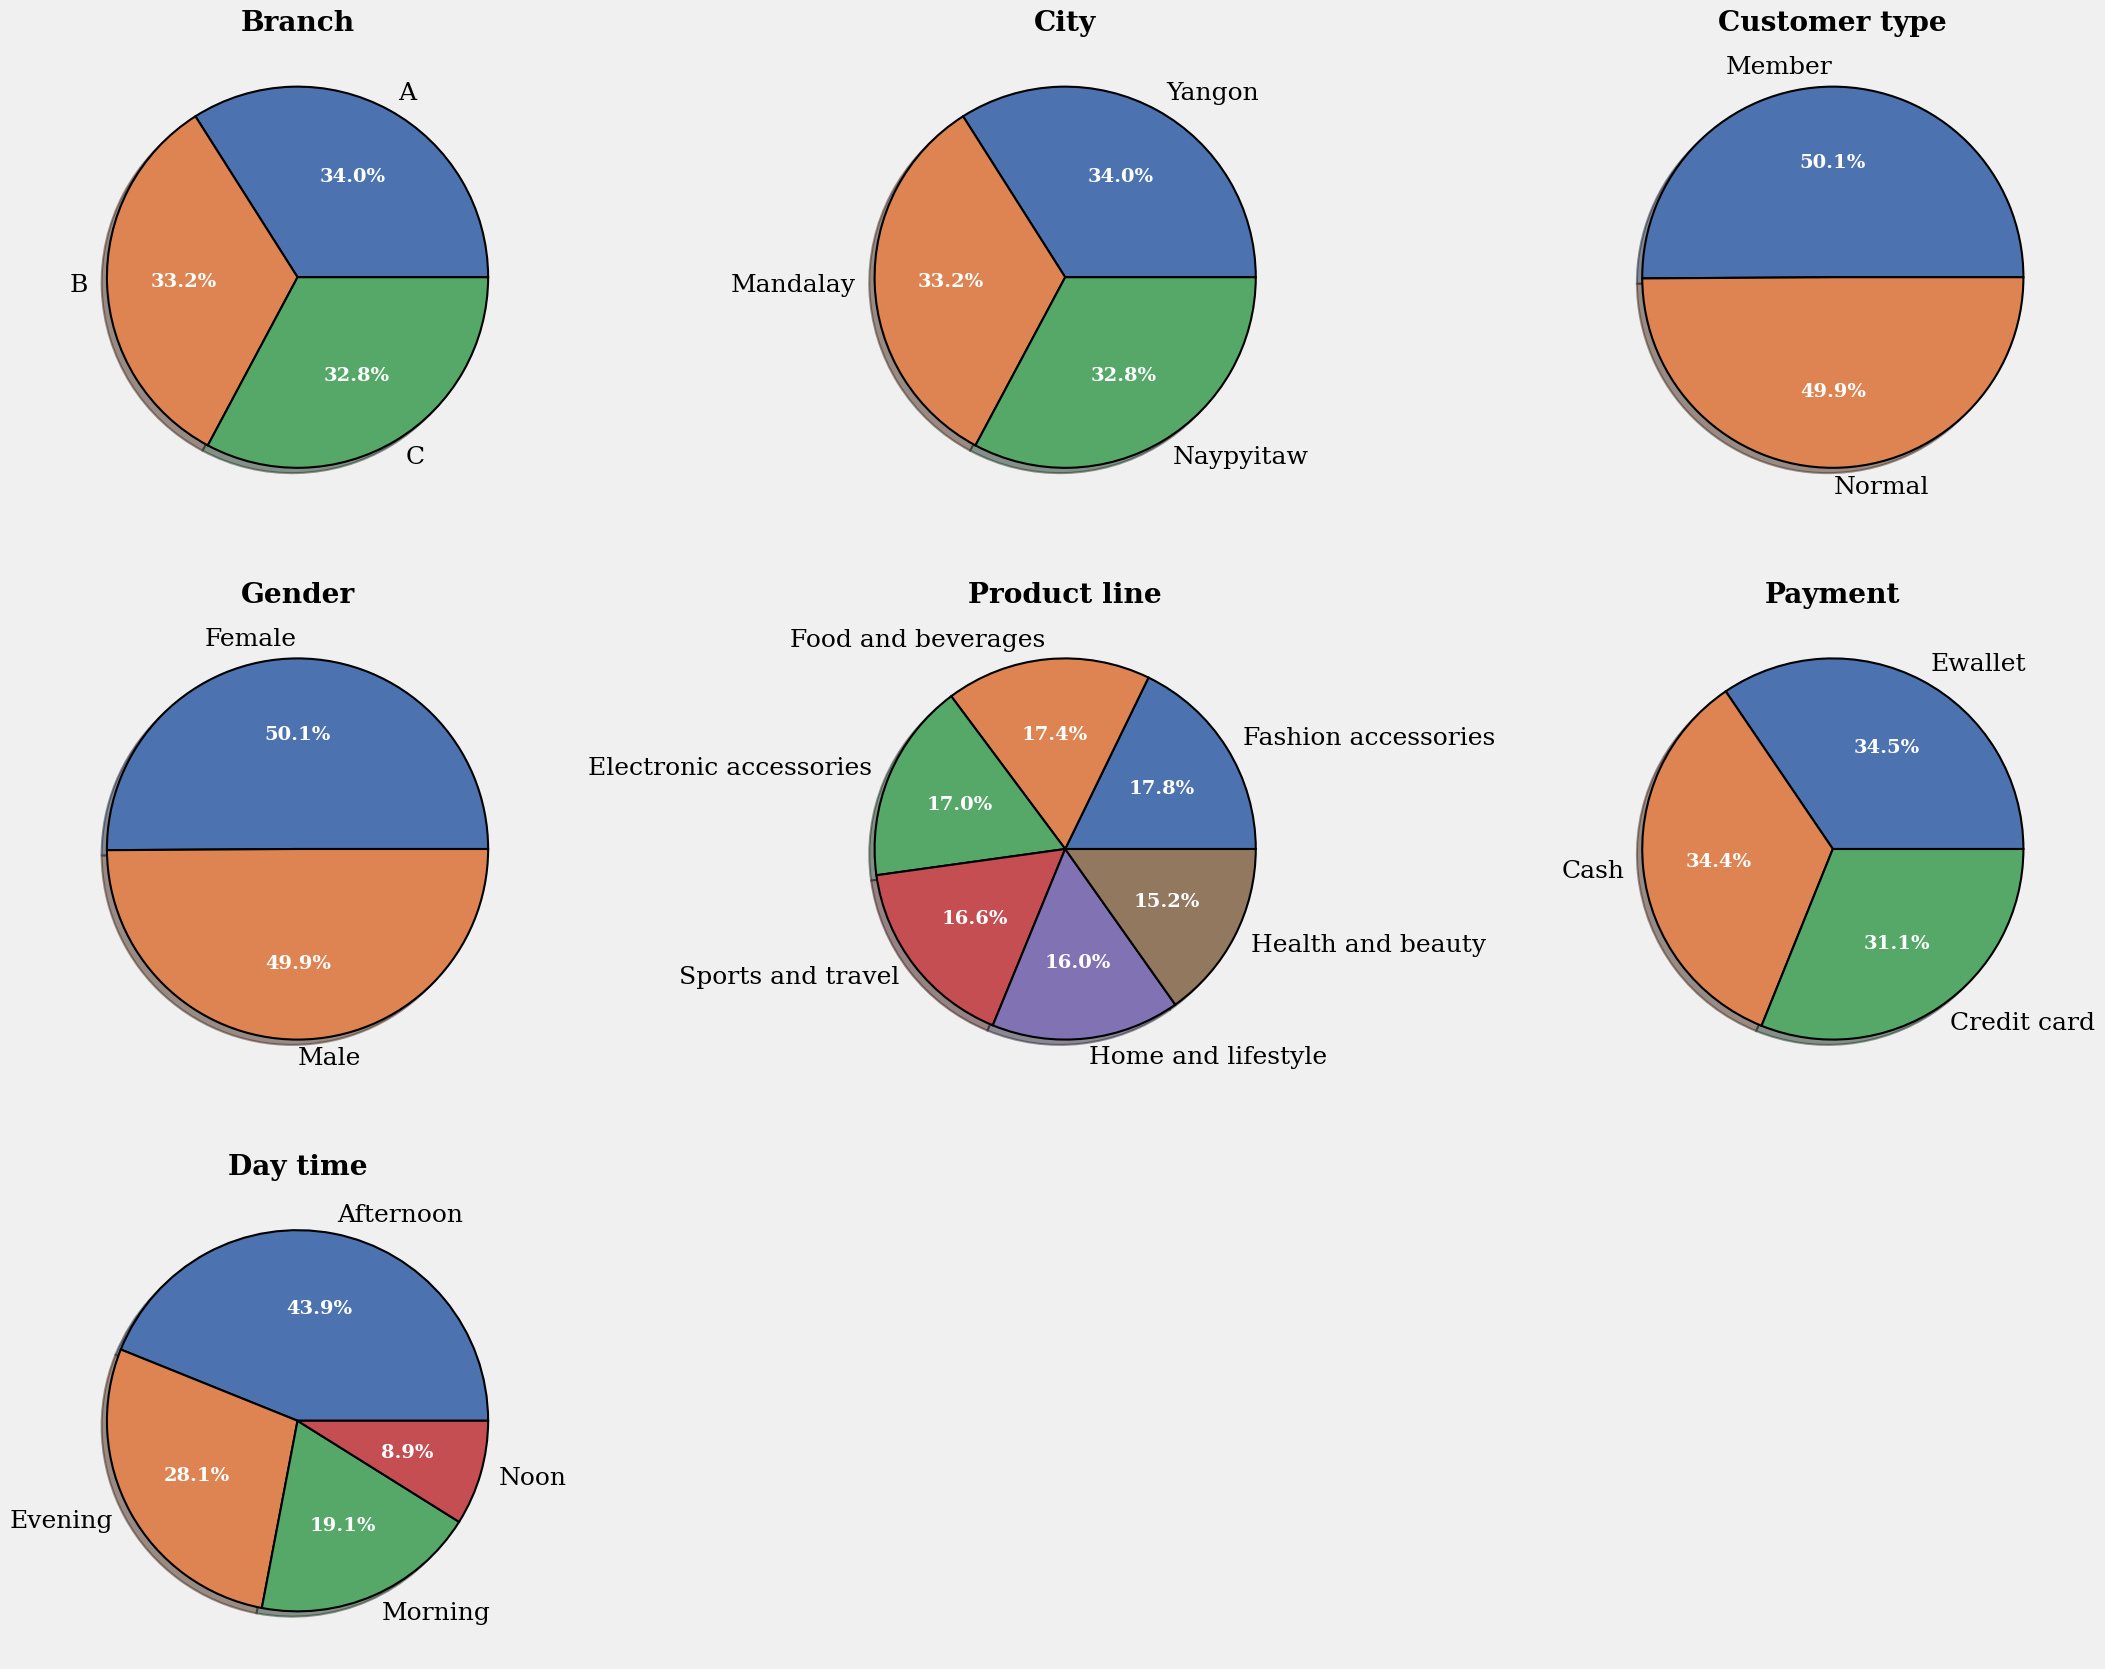

In [ ]:
fig, ax = plt.subplots(3, 3, figsize = (25, 20))
ax = ax.flatten()

for i, col in enumerate(categorical):

    _, _, autotexts = ax[i].pie(df[col].value_counts(), labels = df[col].value_counts().index,
                                autopct='%1.1f%%', textprops = {'fontsize':18, 'fontfamily':'serif'},
                                shadow = True, wedgeprops = {'edgecolor':'black', 'lw':1.5}, colors = palette)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_weight('bold')
        autotext.set_size(14)

    ax[i].set_title(col, fontweight = 'bold', fontfamily='serif')

for i in range(len(categorical), len(ax)):
    fig.delaxes(ax[i])
plt.show()

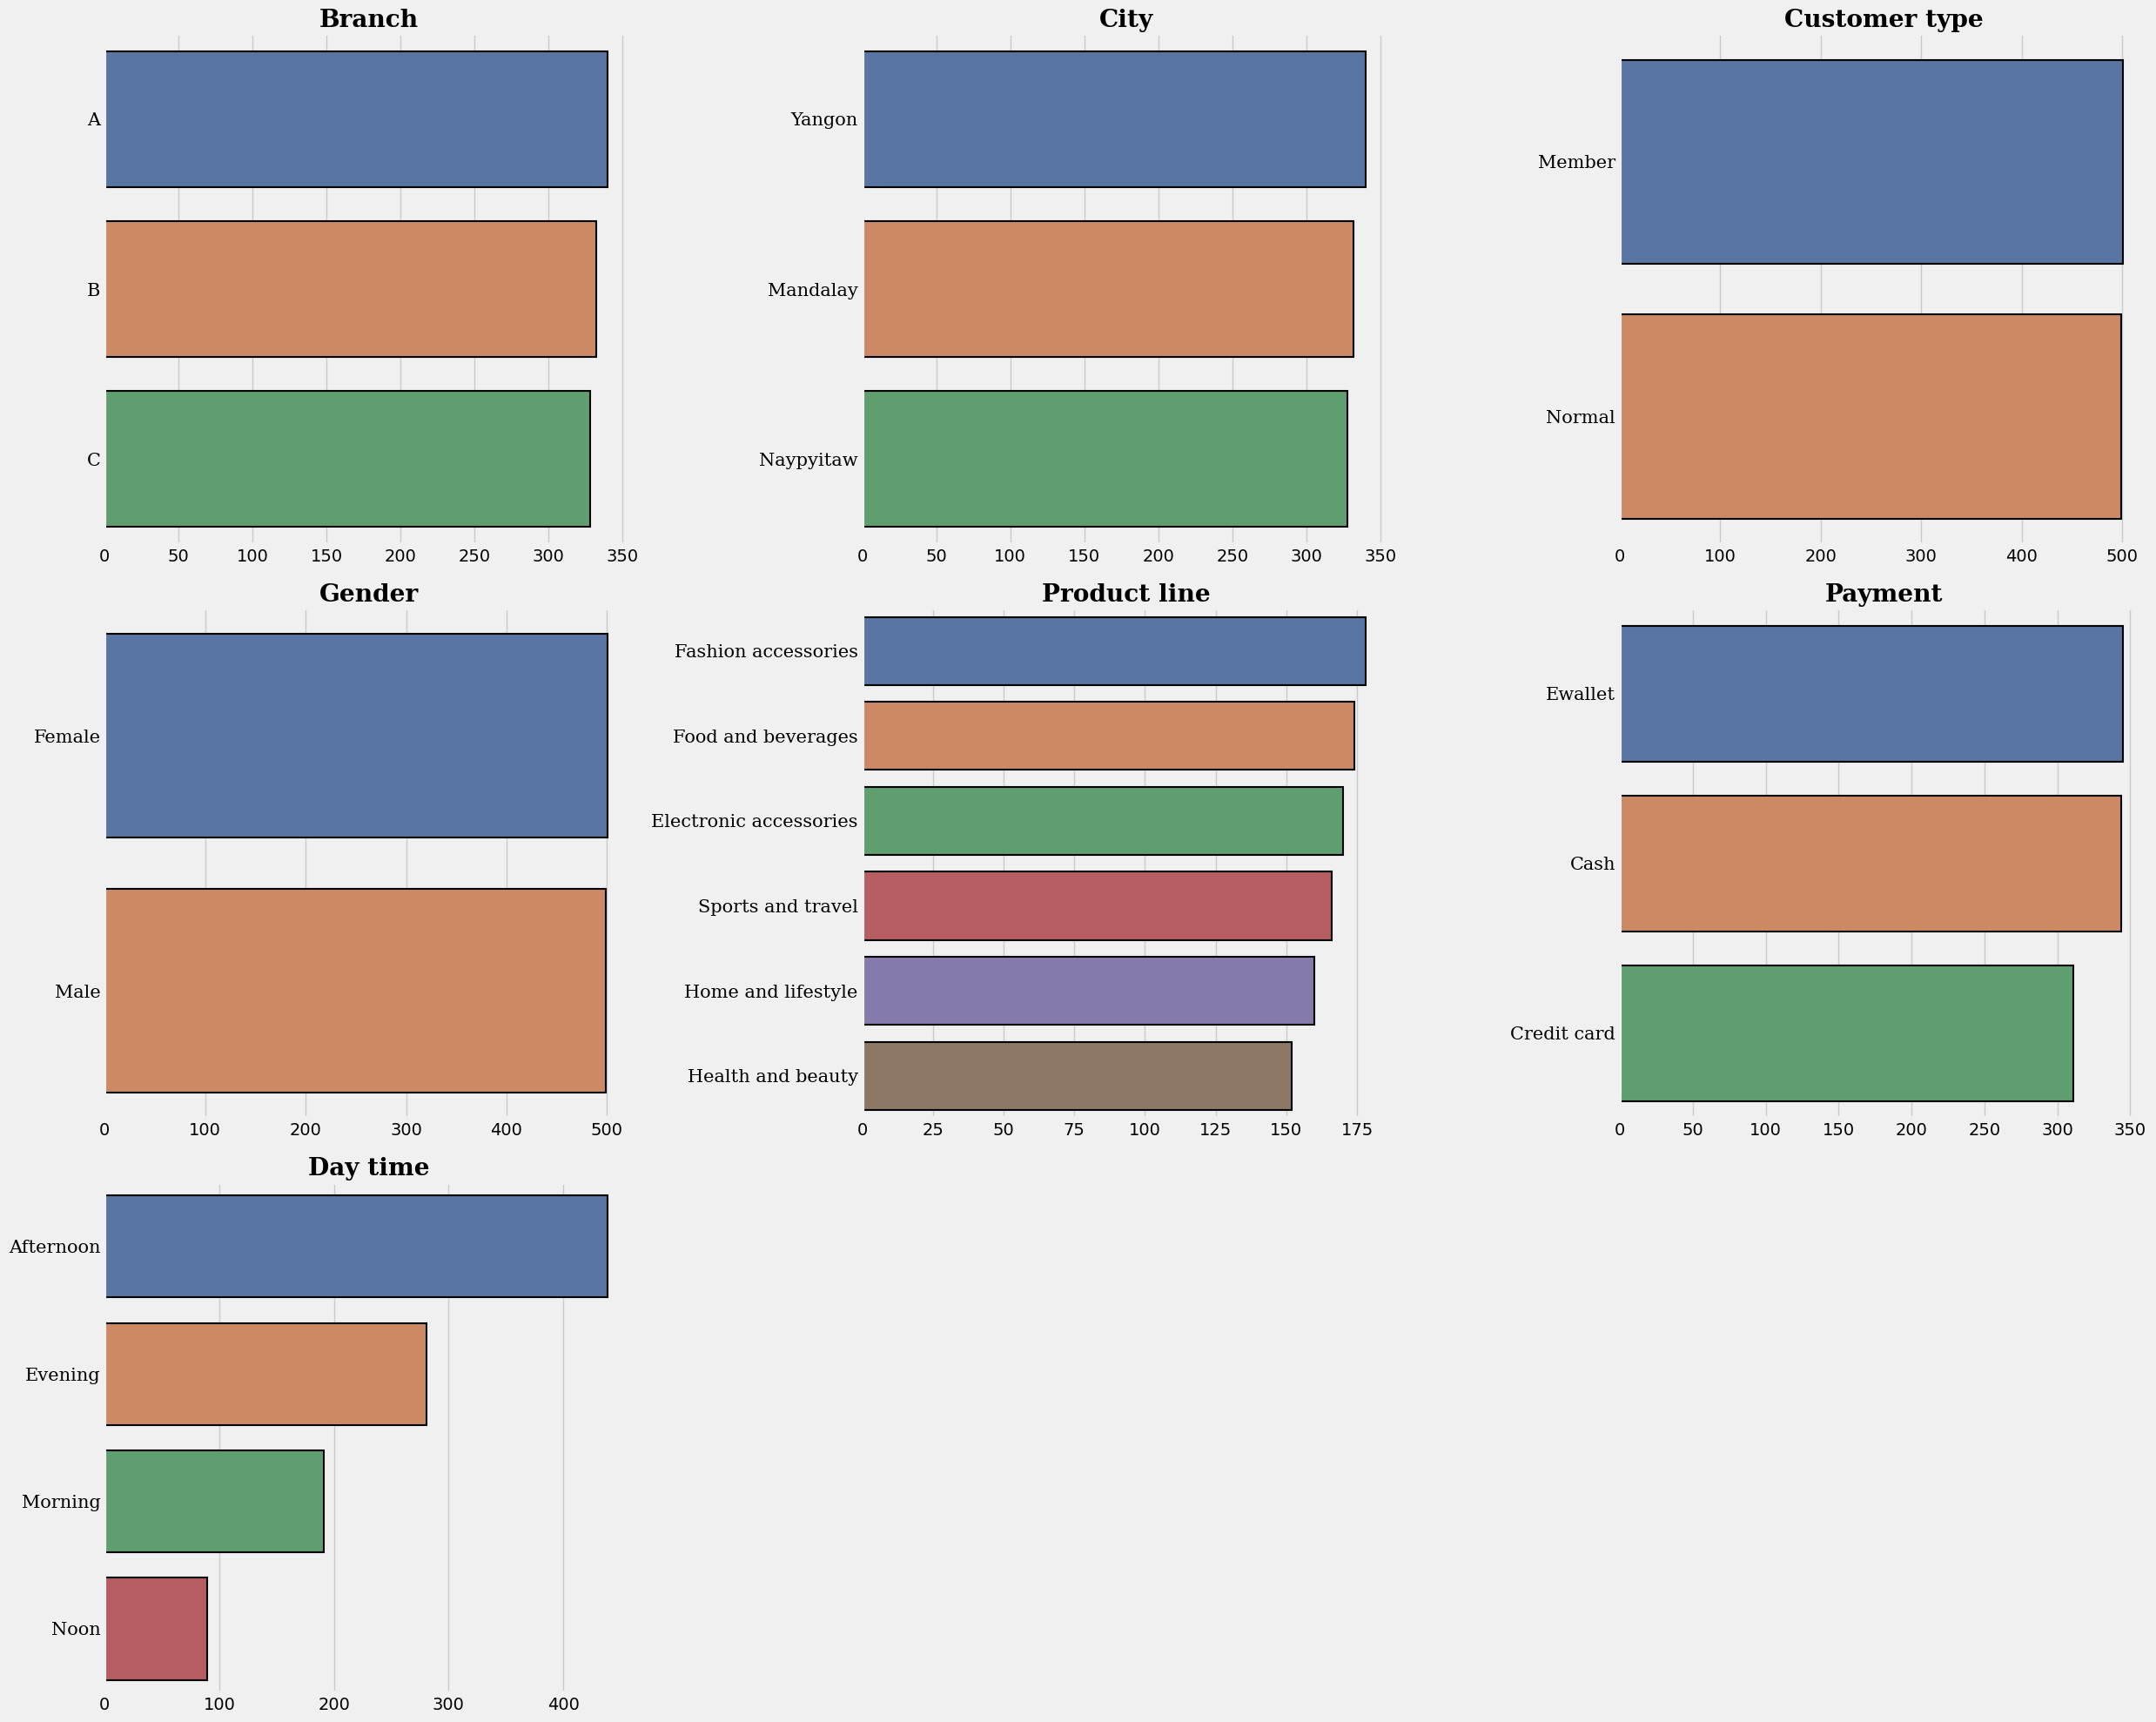

In [ ]:
fig, ax = plt.subplots(3, 3, figsize = (25, 20))
ax = ax.flatten()

for i, col in enumerate(categorical):
    sns.countplot(y = col, data = df, ax = ax[i],
                  palette = palette, edgecolor = 'black',
                  lw = 1.5, order = df[col].value_counts().index)

    ax[i].set_title(col, fontweight = 'bold', fontfamily = 'serif')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_yticklabels(ax[i].get_yticklabels(), fontfamily = 'serif', fontsize = 15)

for i in range(len(categorical), len(ax)):
    fig.delaxes(ax[i])

plt.tight_layout()
plt.show()

In [ ]:
df['Branch'] = df['Branch'].map({'A': 'A || Yangon', 'B': 'B || Mandalay', 'C': 'C || Naypyitaw'})
df.drop('City', axis=1, inplace=True)

In [ ]:
df.head()

,Branch,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Payment,cogs,gross margin percentage,gross income,Rating,Day time
0,A || Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,Ewallet,522.83,4.761905,26.1415,9.1,Afternoon
1,C || Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,Cash,76.40,4.761905,3.8200,9.6,Morning
2,A || Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,Credit card,324.31,4.761905,16.2155,7.4,Afternoon
3,A || Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,Ewallet,465.76,4.761905,23.2880,8.4,Evening
4,A || Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,Ewallet,604.17,4.761905,30.2085,5.3,Morning


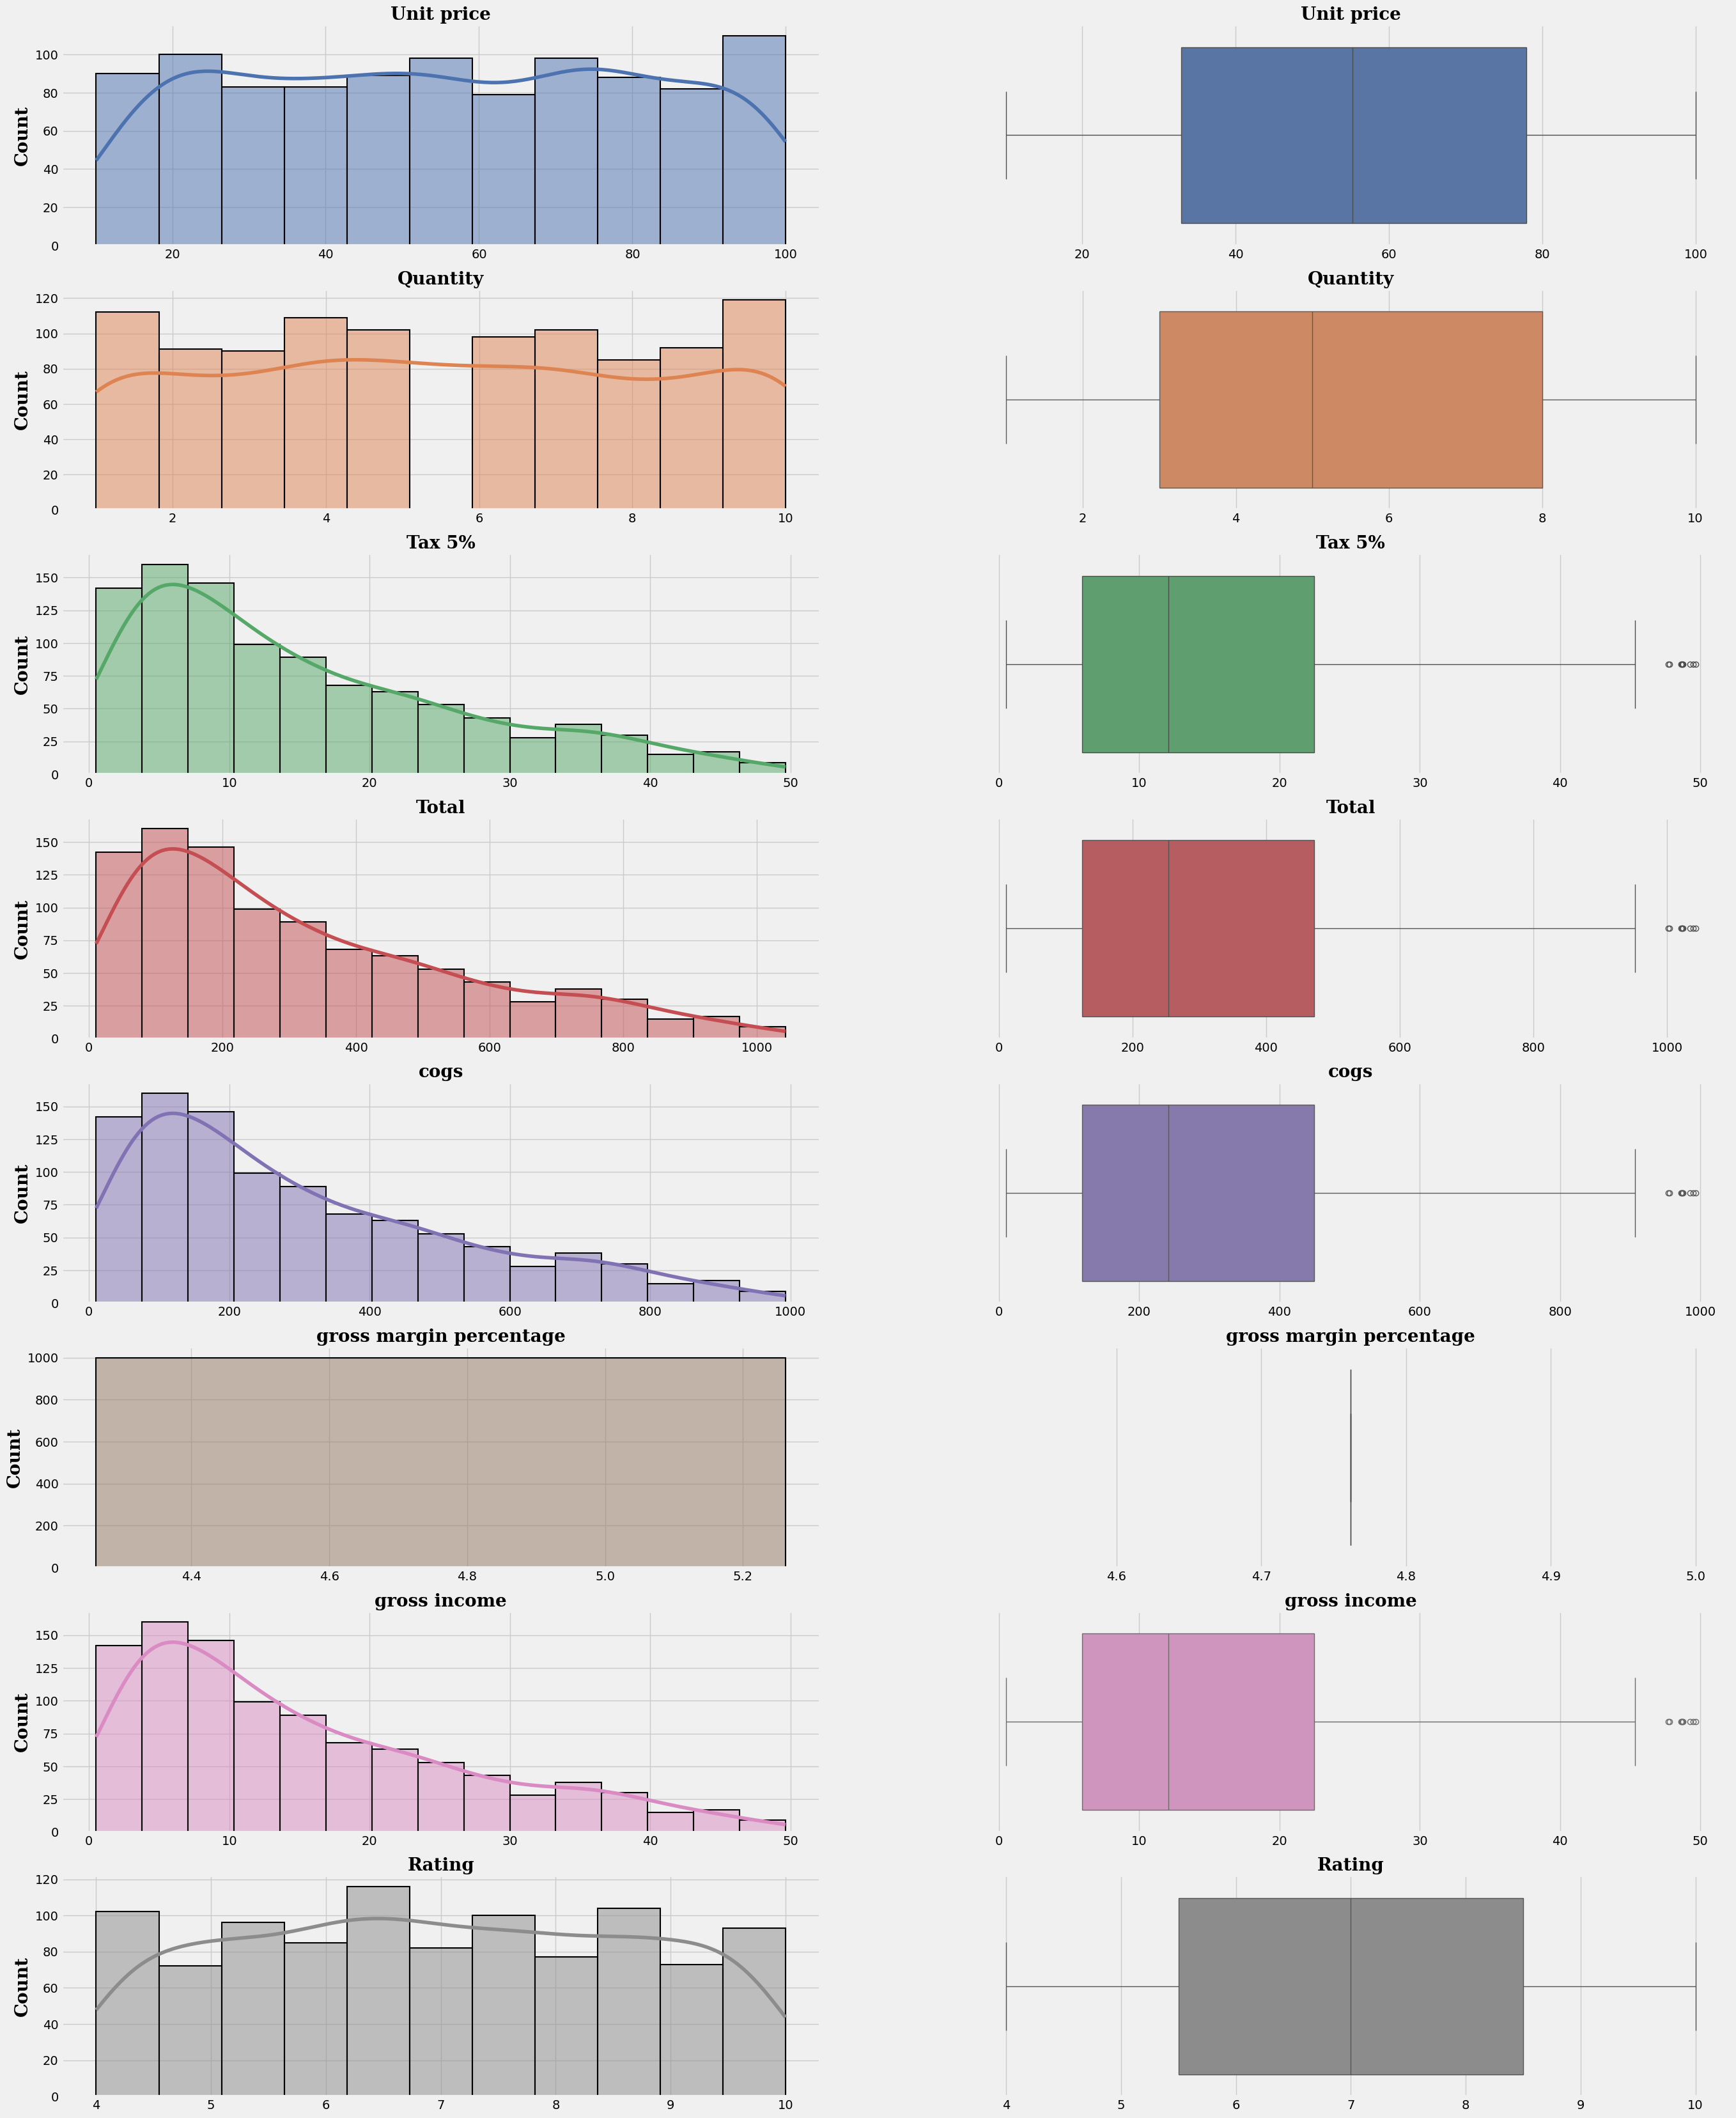

In [ ]:
fig, ax = plt.subplots(8, 2, figsize = (30, 40))
ax = ax.flatten()
for i, col in enumerate(numerical):
    sns.histplot(x = col, data=df, ax=ax[2 * i],
                 color=palette[i], kde=True, lw=1.5, edgecolor='black')

    ax[2*i].set_title(col, fontweight = 'bold', fontfamily='serif', fontsize=20)
    ax[2*i].set_xlabel('')
    ax[2*i].set_ylabel('Count',fontweight = 'bold', fontfamily='serif', fontsize=20)


    sns.boxplot(x = col, data=df, ax=ax[2 * i+1], color=palette[i])

    ax[2 * i+1].set_title(col, fontweight = 'bold', fontfamily='serif', fontsize=20)
    ax[2 * i+1].set_xlabel('')
    ax[2 * i+1].set_ylabel('')

plt.show()

In [ ]:
df.head()

,Branch,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Payment,cogs,gross margin percentage,gross income,Rating,Day time
0,A || Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,Ewallet,522.83,4.761905,26.1415,9.1,Afternoon
1,C || Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,Cash,76.40,4.761905,3.8200,9.6,Morning
2,A || Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,Credit card,324.31,4.761905,16.2155,7.4,Afternoon
3,A || Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,Ewallet,465.76,4.761905,23.2880,8.4,Evening
4,A || Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,Ewallet,604.17,4.761905,30.2085,5.3,Morning


In [ ]:
def setup_graph_legend(legend_title, x_label, y_label, graph_title):

    plt.legend(fontsize = 15, title = legend_title, loc='upper right',
                shadow = True, frameon = True, title_fontproperties={'weight':'bold', 'size':'20', 'family':'serif'})

    plt.xlabel(x_label, fontsize = 20, fontweight = 'bold', fontfamily = 'serif', labelpad=20)
    plt.ylabel(y_label, fontsize = 20, fontweight = 'bold', fontfamily = 'serif', labelpad=20)
    plt.title(graph_title, fontsize = 20, fontweight = 'bold', fontfamily = 'serif')

    plt.xticks(fontsize = 18, fontfamily = 'serif')
    plt.yticks(fontsize = 15, fontfamily = 'serif')


def setup_graph(x_label, y_label, graph_title):

    plt.xlabel(x_label, fontsize = 20, fontweight = 'bold', fontfamily = 'serif', labelpad=20)
    plt.ylabel(y_label, fontsize = 20, fontweight = 'bold', fontfamily = 'serif', labelpad=20)
    plt.title(graph_title, fontsize = 20, fontweight = 'bold', fontfamily = 'serif')

    plt.xticks(fontsize = 18, fontfamily = 'serif')
    plt.yticks(fontsize = 15, fontfamily = 'serif')


In [ ]:
#1. What is the most time that people buy in each city and branch?

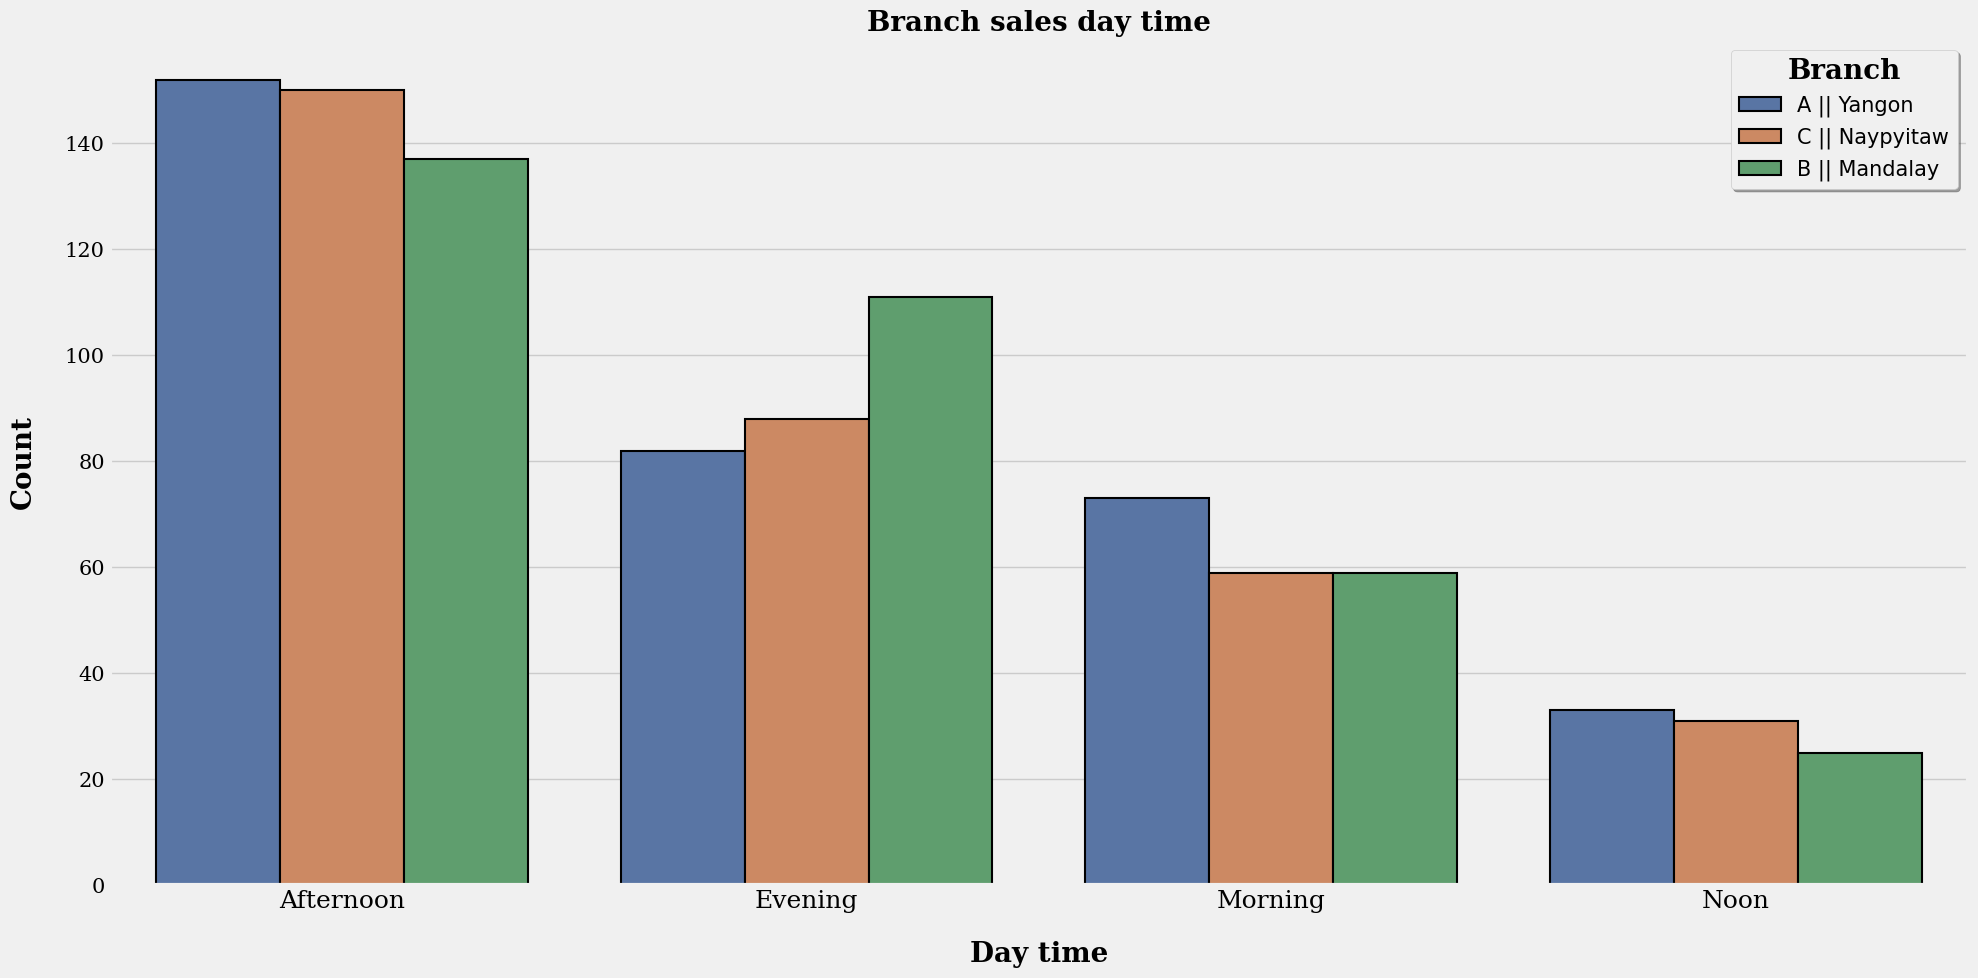

In [ ]:
plt.figure(figsize=(20, 10))
sns.countplot(x = 'Day time', data = df, palette = palette,
              edgecolor = 'black', linewidth = 1.5, hue='Branch',
              order = df['Day time'].value_counts().index)

setup_graph_legend('Branch', 'Day time', 'Count', 'Branch sales day time')

plt.tight_layout()
plt.show()

In [ ]:
#2. Which branch is the most average quantity of selling?

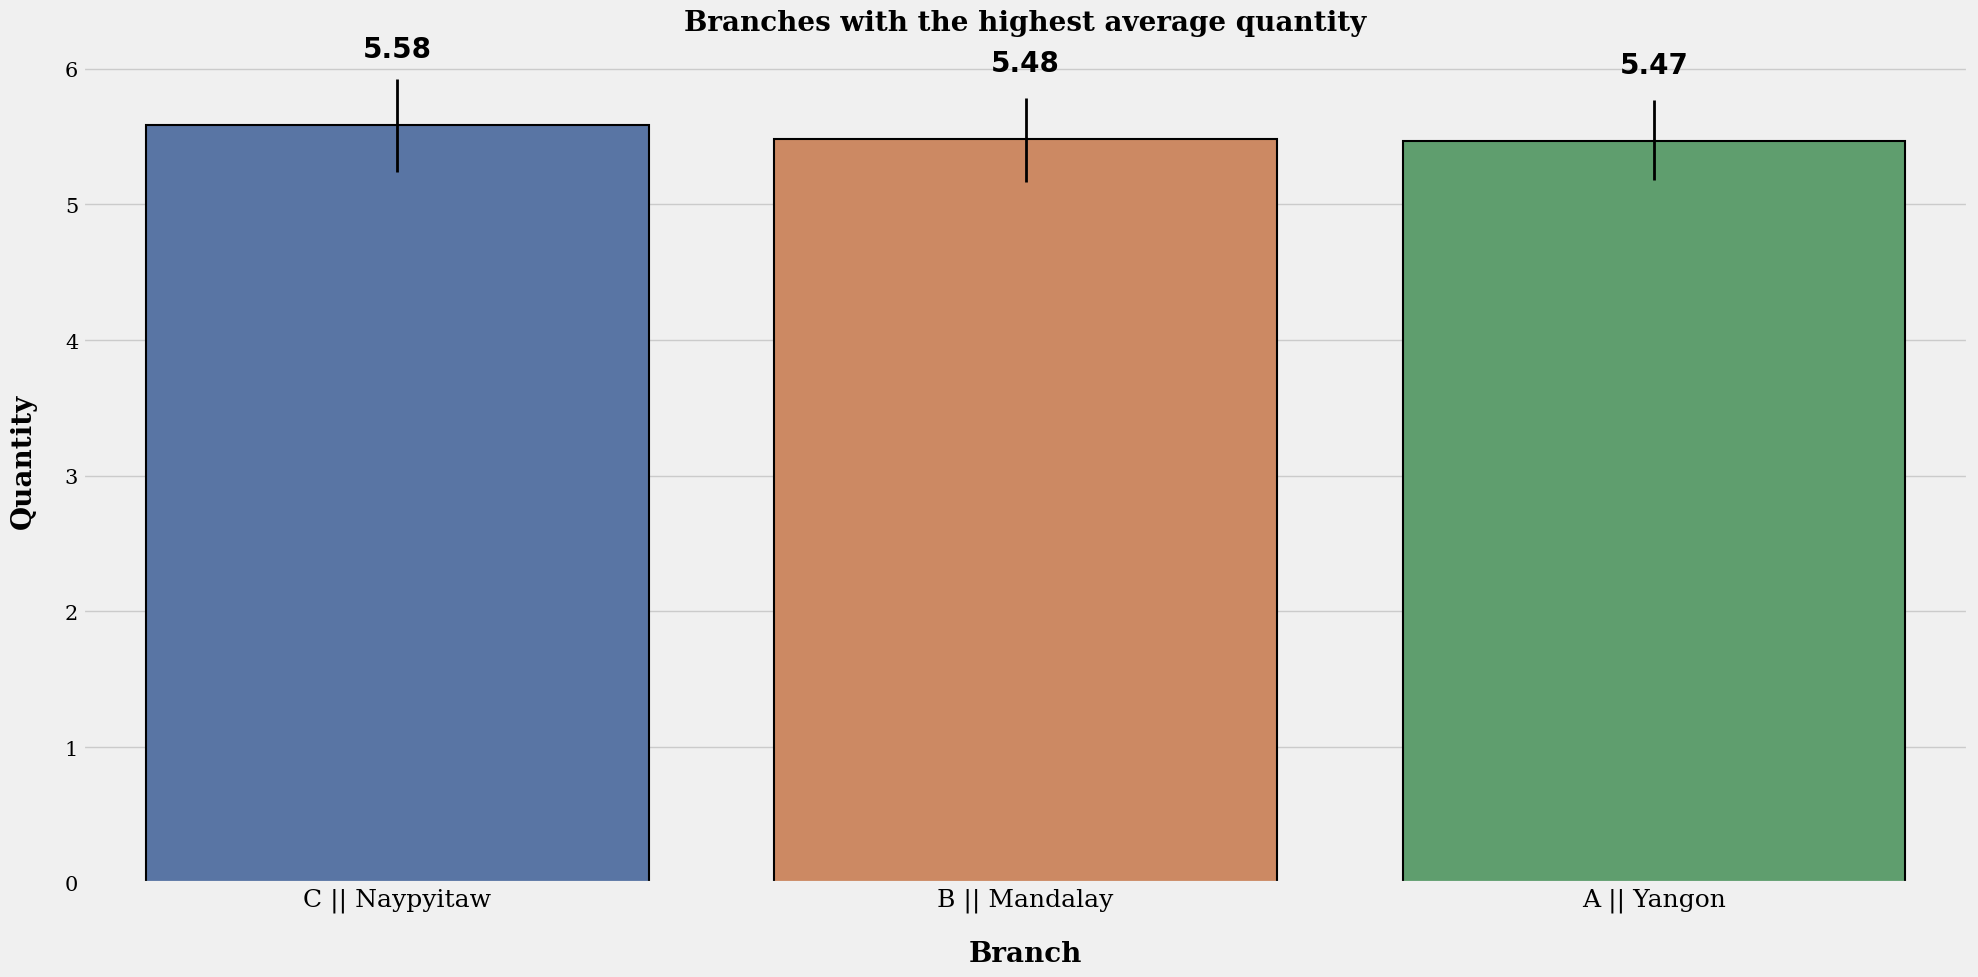

In [ ]:
plt.figure(figsize=(20, 10))

sns.barplot(x = 'Branch', y = 'Quantity', data = df, palette = palette,
            order = df.groupby('Branch')['Quantity'].mean().sort_values(ascending = False).index,
            edgecolor = 'black', errcolor = 'black', errwidth = 2, lw = 1.5)

for i in range(3):
    plt.text(i, df.groupby('Branch')['Quantity'].mean().sort_values(ascending = False)[i] + 0.5,
             round(df.groupby('Branch')['Quantity'].mean().sort_values(ascending = False)[i], 2),
             ha = 'center', fontdict = {'weight':'bold', 'size':20}, color = 'black')


setup_graph('Branch', 'Quantity', 'Branches with the highest average quantity')

plt.tight_layout()
plt.show()

In [ ]:
#3. Which branch have the most average gross income?

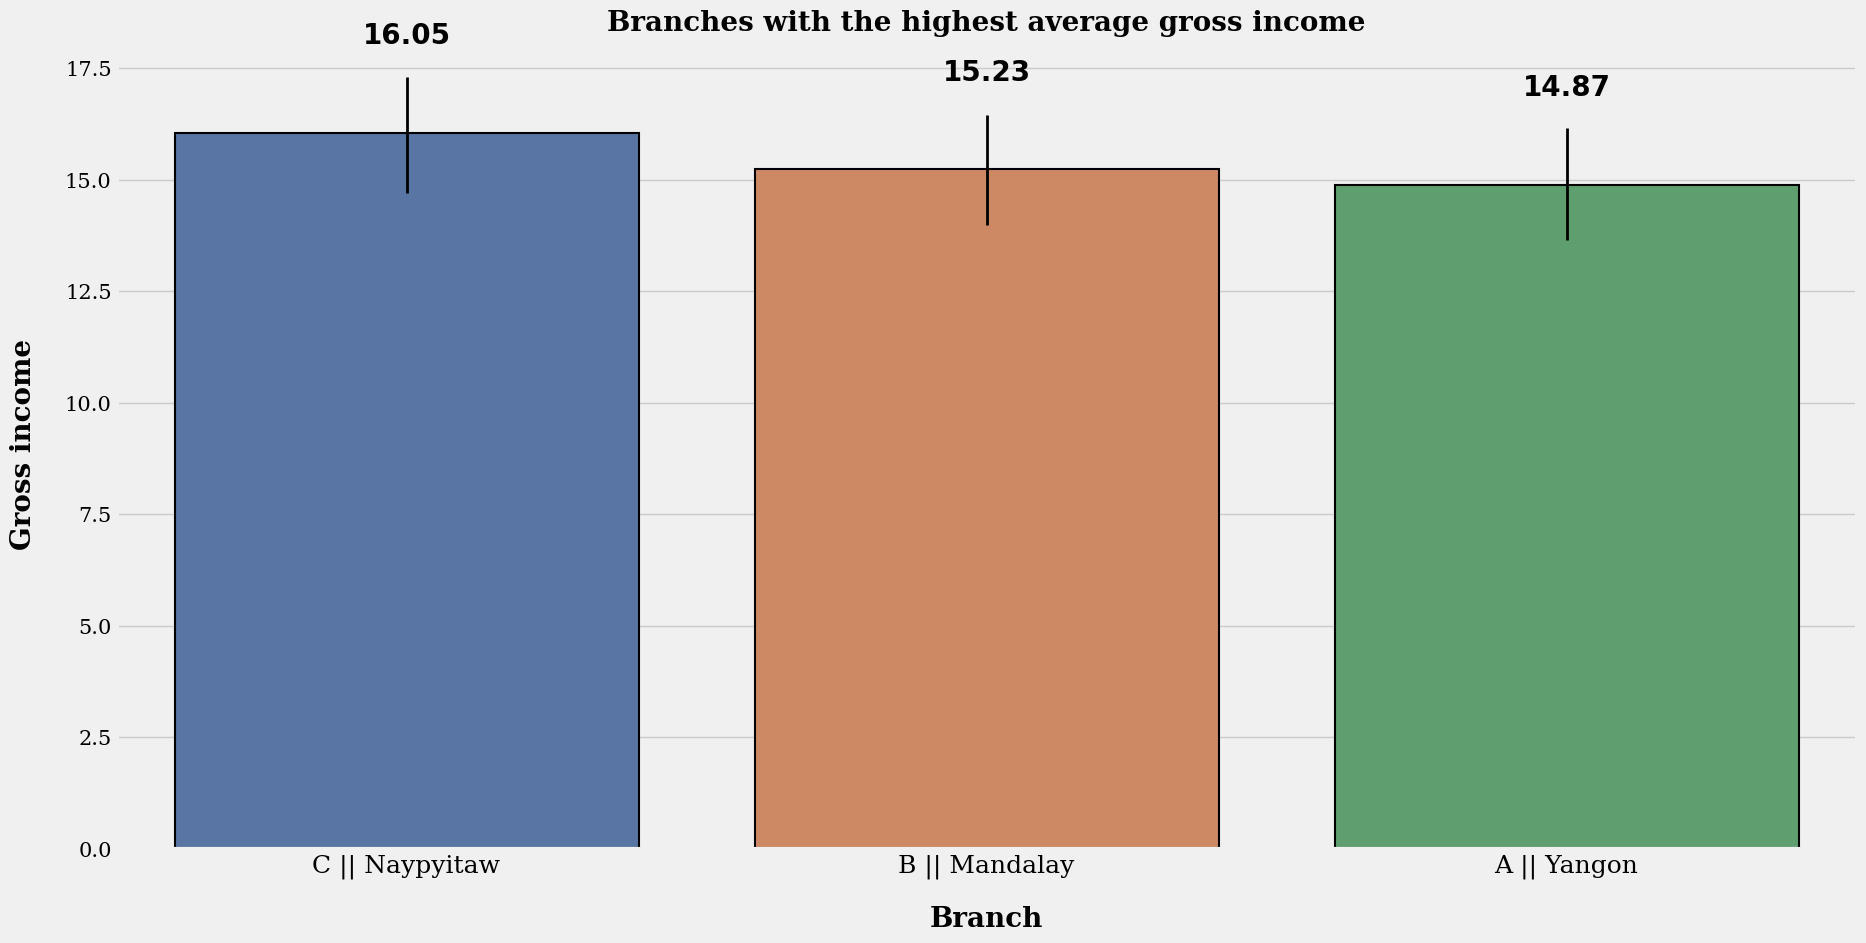

In [ ]:
plt.figure(figsize=(20, 10))

sns.barplot(x = 'Branch', y = 'gross income', data = df, palette = palette,
            order = df.groupby('Branch')['gross income'].mean().sort_values(ascending = False).index,
            edgecolor = 'black', errcolor = 'black', errwidth = 2, lw = 1.5)

for i in range(3):
    plt.text(i, df.groupby('Branch')['gross income'].mean().sort_values(ascending = False)[i] + 2,
             round(df.groupby('Branch')['gross income'].mean().sort_values(ascending = False)[i], 2),
             ha = 'center', fontdict = {'weight':'bold', 'size':20}, color = 'black')

setup_graph('Branch', 'Gross income', 'Branches with the highest average gross income')

plt.show()

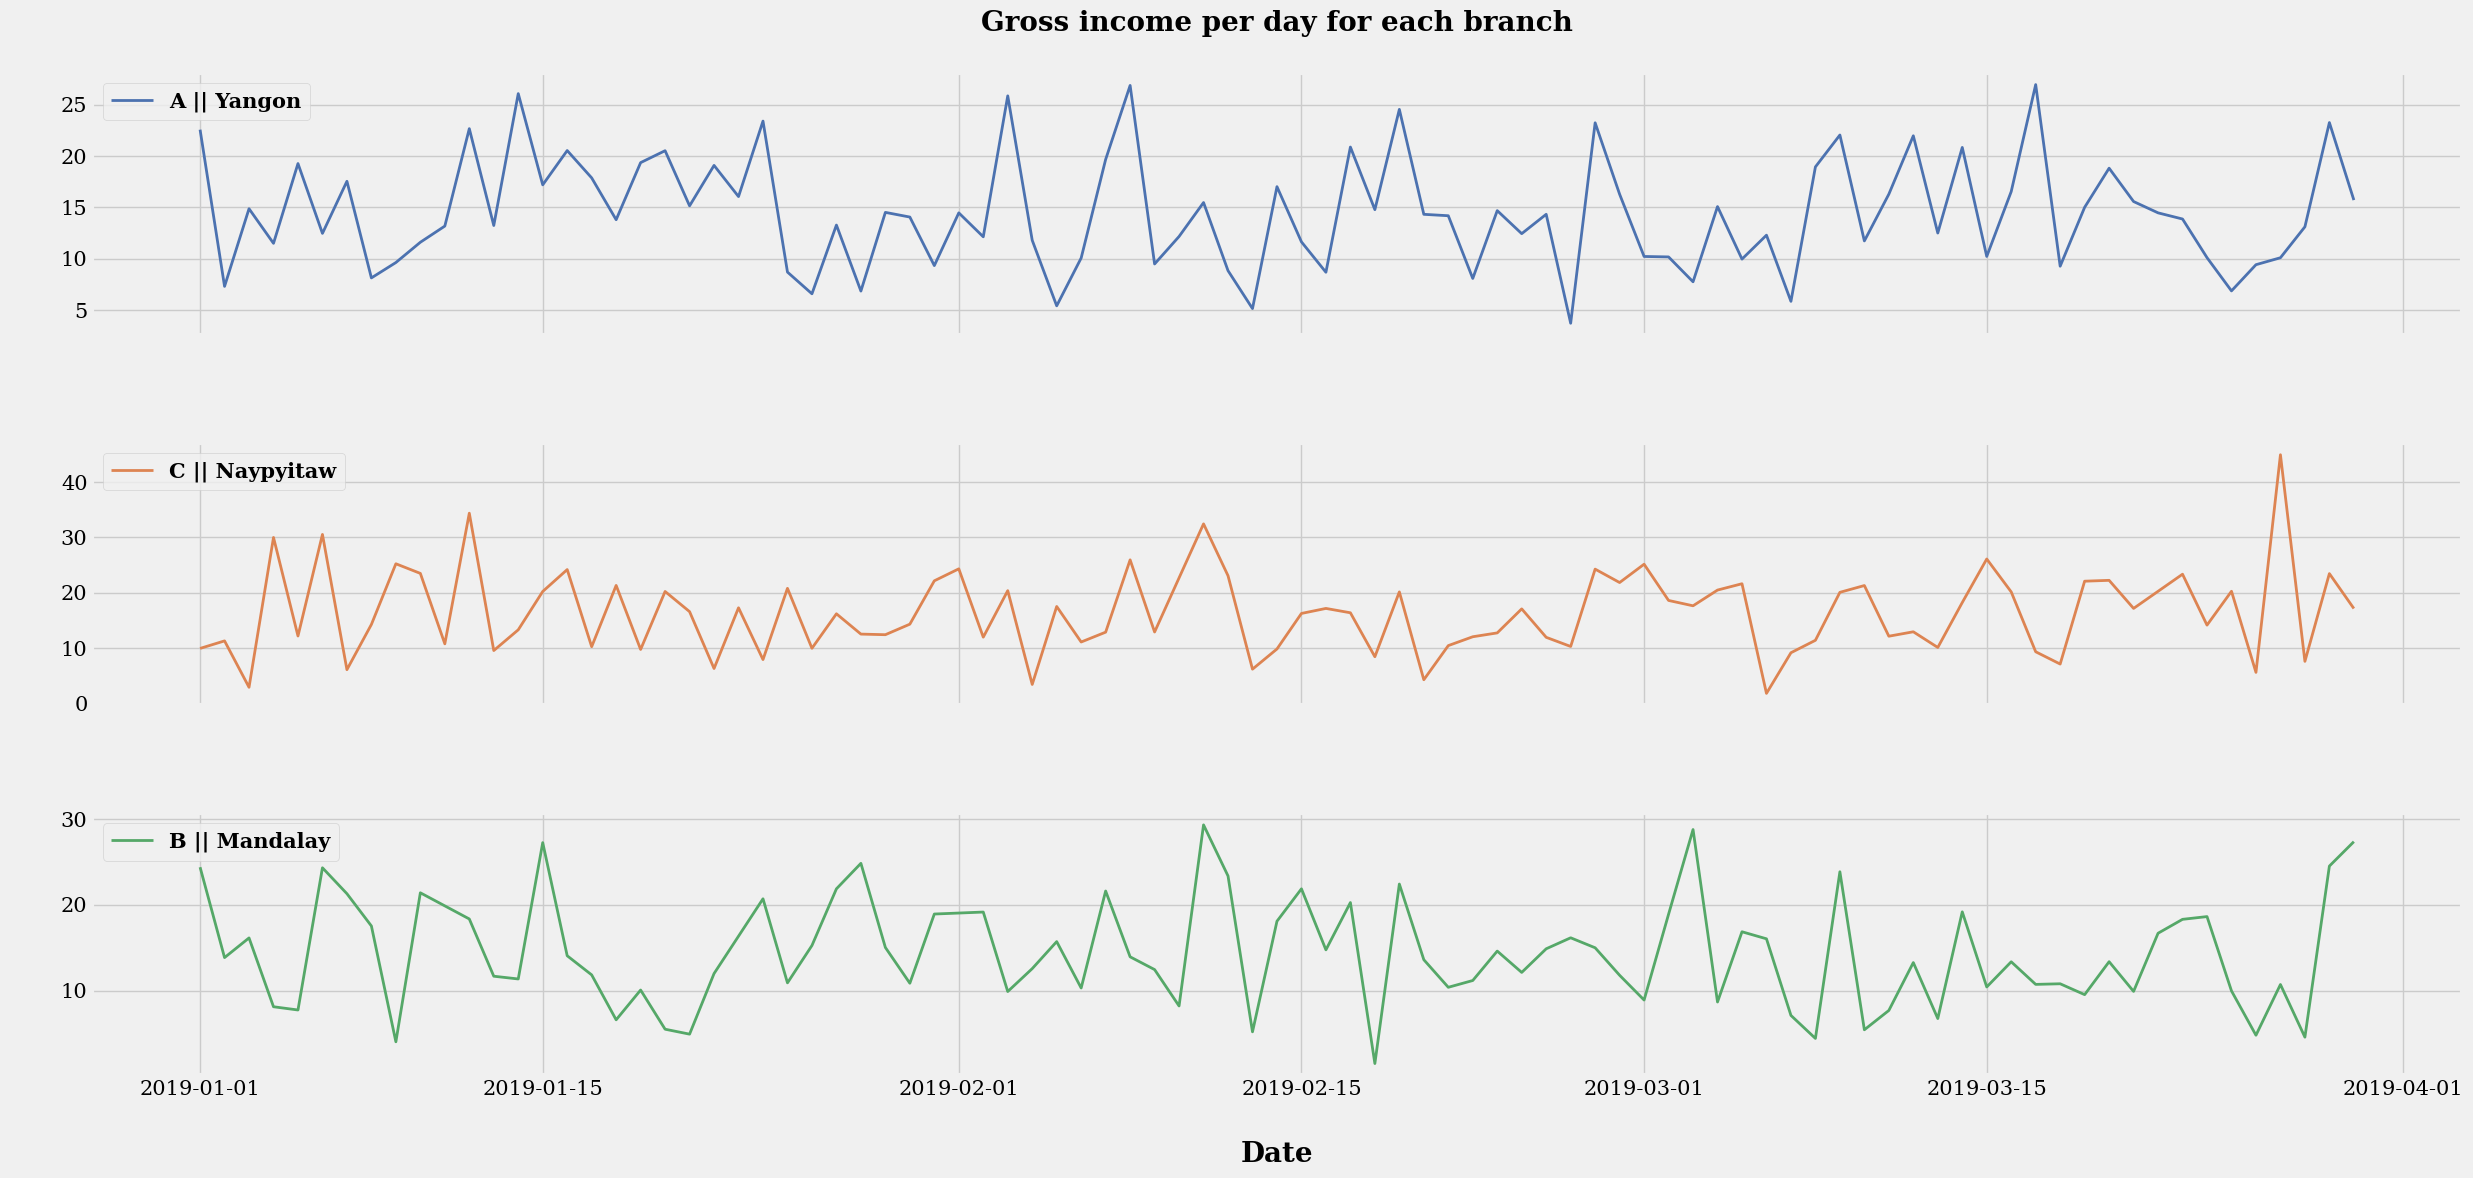

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (25, 12), sharex=True)

for i, col in enumerate(df.Branch.unique()):
    sns.lineplot(x = 'Date', y = 'gross income', data = df[df['Branch'] == col],
                lw = 2, color = palette[i], ax = ax[i], errorbar=None)

    ax[i].set_xlabel('')
    ax[i].set_xlabel('Date', fontsize = 20, fontweight = 'bold', fontfamily = 'serif', labelpad=30)
    ax[i].set_ylabel(' ', labelpad = 20)

    labels = ax[i].get_xticklabels() + ax[i].get_yticklabels()
    [label.set_fontname('serif') for label in labels]
    [label.set_fontsize(15) for label in labels]

    ax[i].legend([col], fontsize = 15, loc = 'upper left',
                prop={'weight':'bold', 'size':'15', 'family':'serif'})

ax[0].set_title('Gross income per day for each branch',
                fontsize = 20, fontweight = 'bold', fontfamily = 'serif', pad=30)
plt.tight_layout(h_pad=5)
plt.show()

In [ ]:
#4.4. What time do members prefer to buy at?

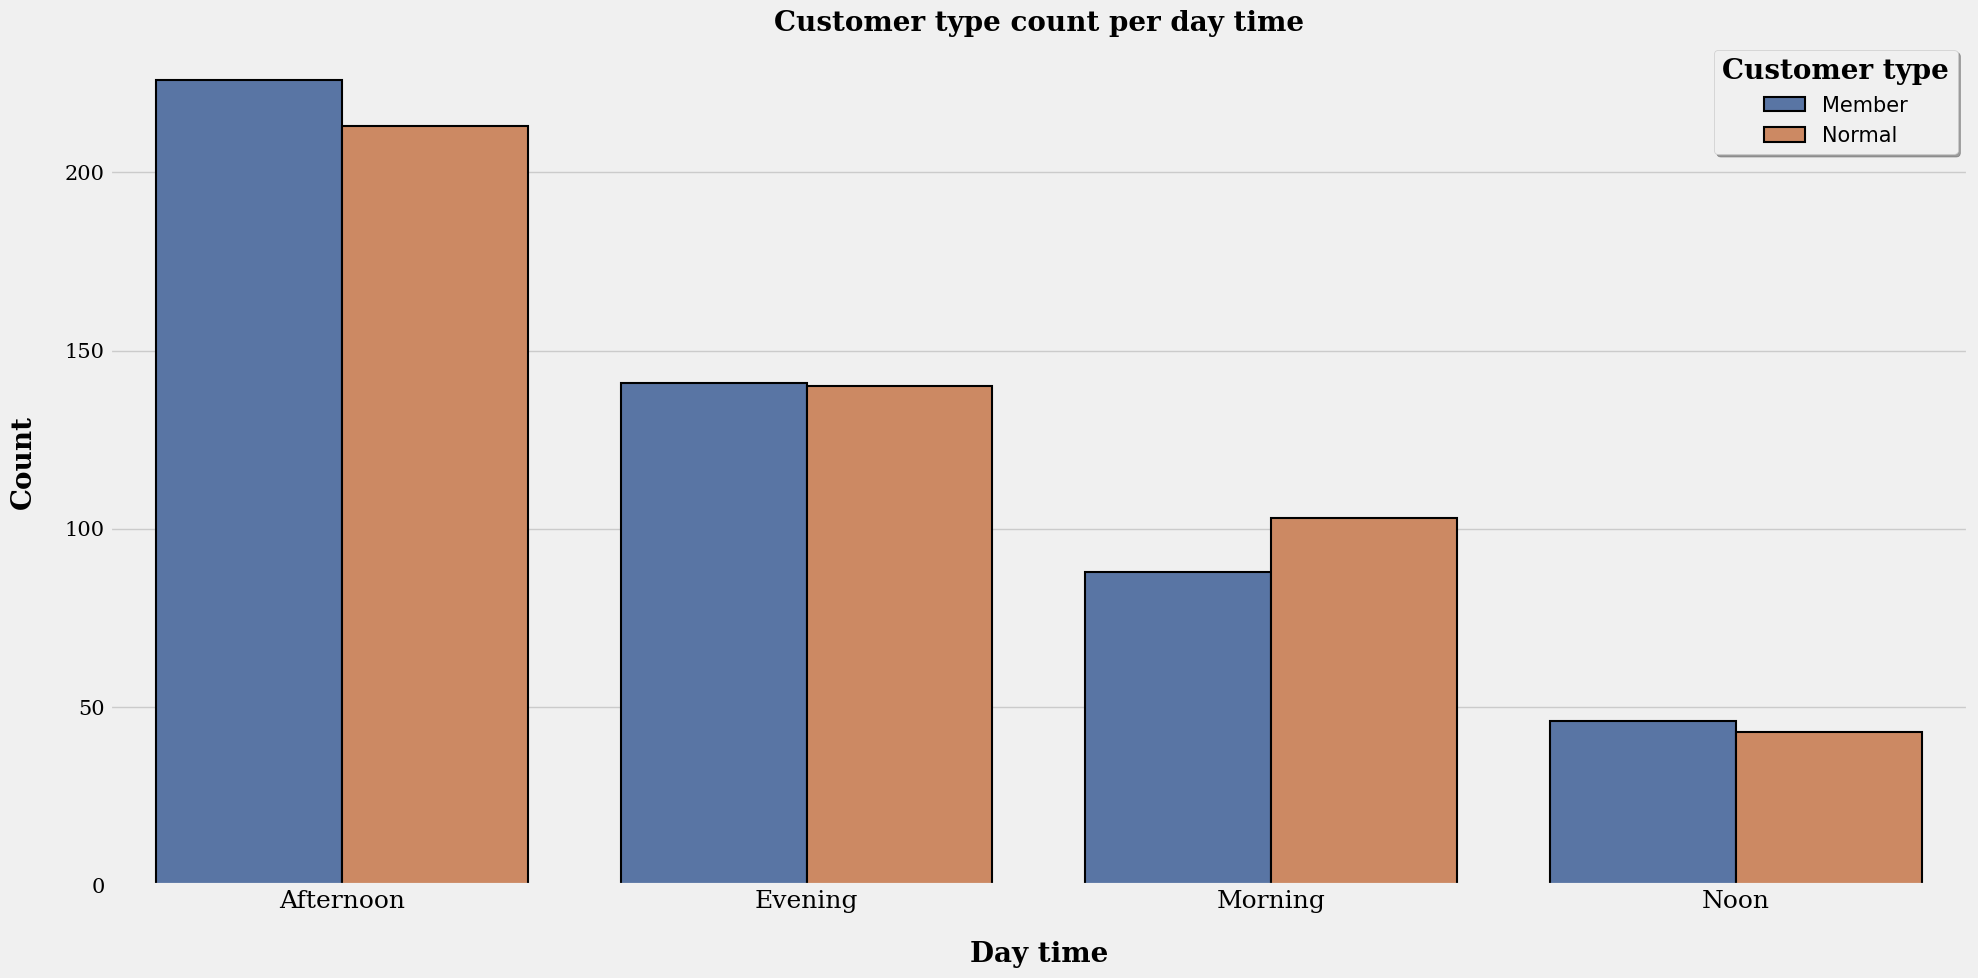

In [ ]:
plt.figure(figsize=(20, 10))

sns.countplot(x='Day time', data=df, hue='Customer type', palette=palette,
                edgecolor='black', lw=1.5, order = df['Day time'].value_counts().index)

setup_graph_legend('Customer type', 'Day time', 'Count', 'Customer type count per day time')

plt.tight_layout()
plt.show()

In [ ]:
#5. What is the most successful product line in each branch?

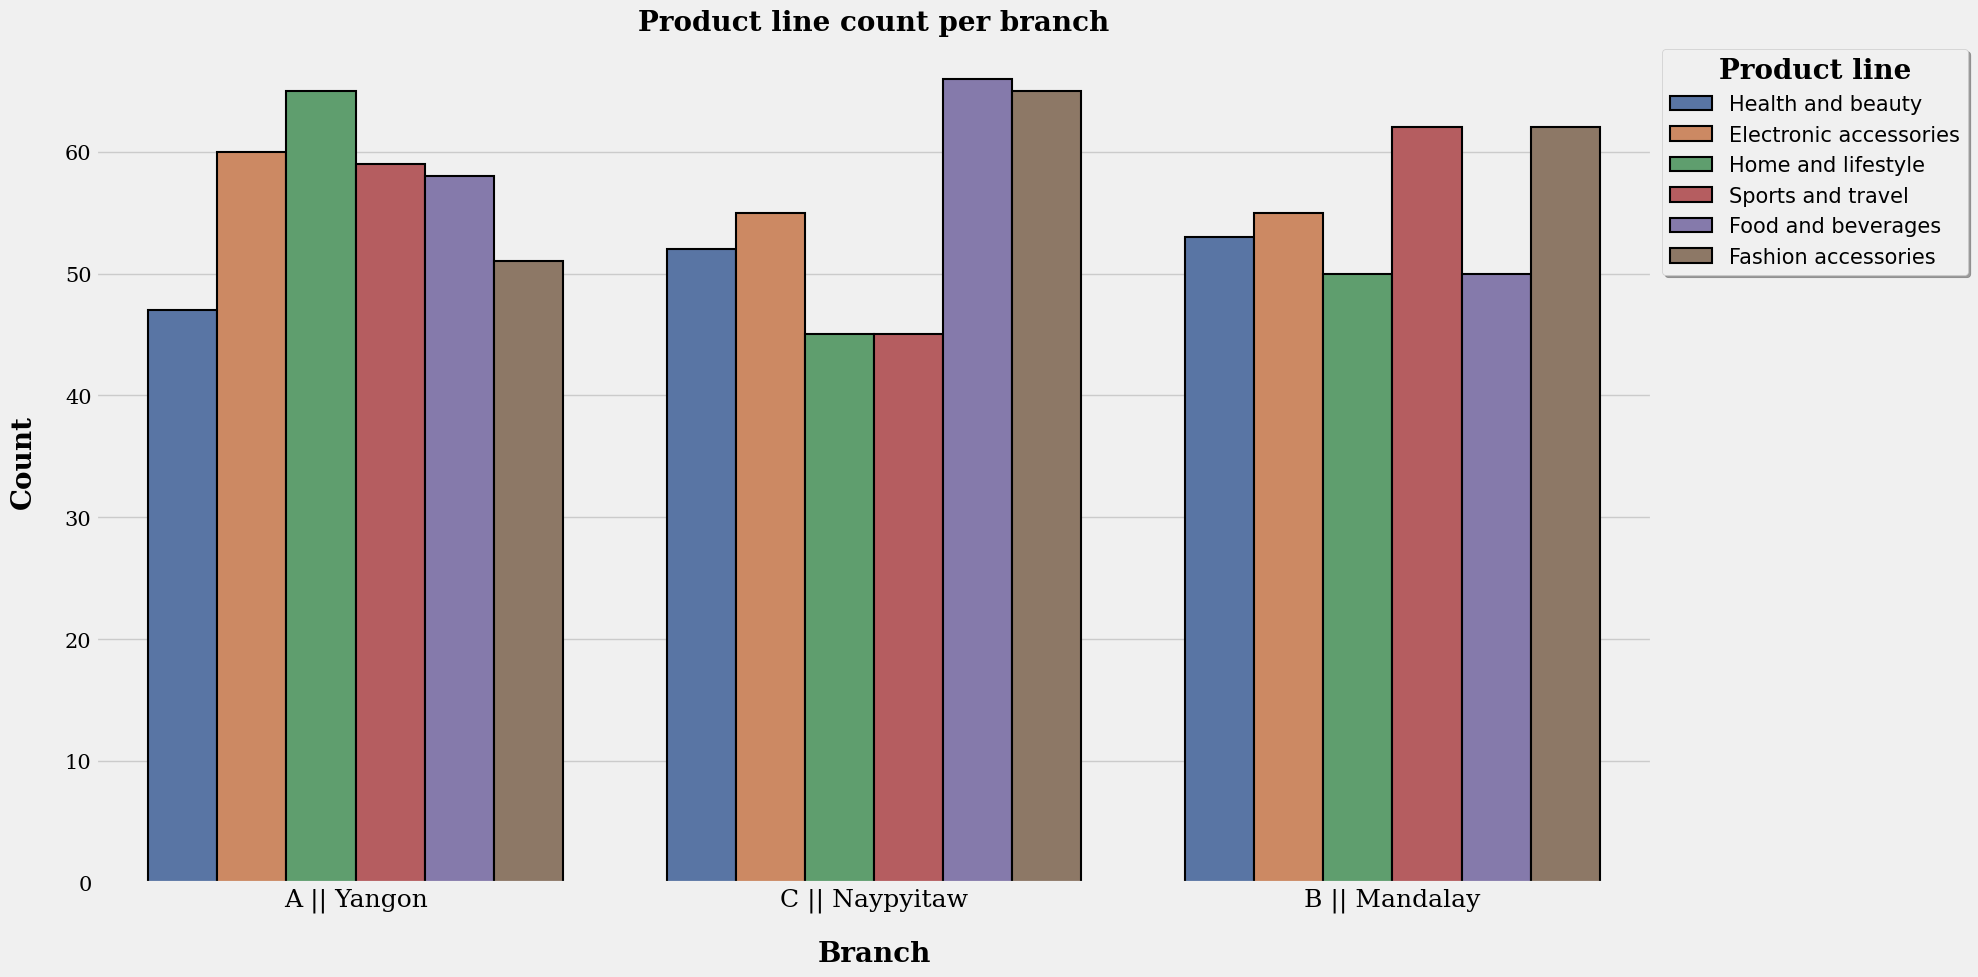

In [ ]:
plt.figure(figsize=(20, 10))
sns.countplot(x = 'Branch', data = df, palette = palette,
              hue='Product line', lw=1.5, edgecolor='black')

setup_graph('Branch', 'Count', 'Product line count per branch')

plt.legend(fontsize = 15, title = 'Product line', bbox_to_anchor=(1, 1), loc='upper left',
            shadow = True, frameon = True, title_fontproperties={'weight':'bold', 'size':'20', 'family':'serif'})

plt.tight_layout()
plt.show()

In [ ]:
#6. What is the most preferable payment method with each type of customers?

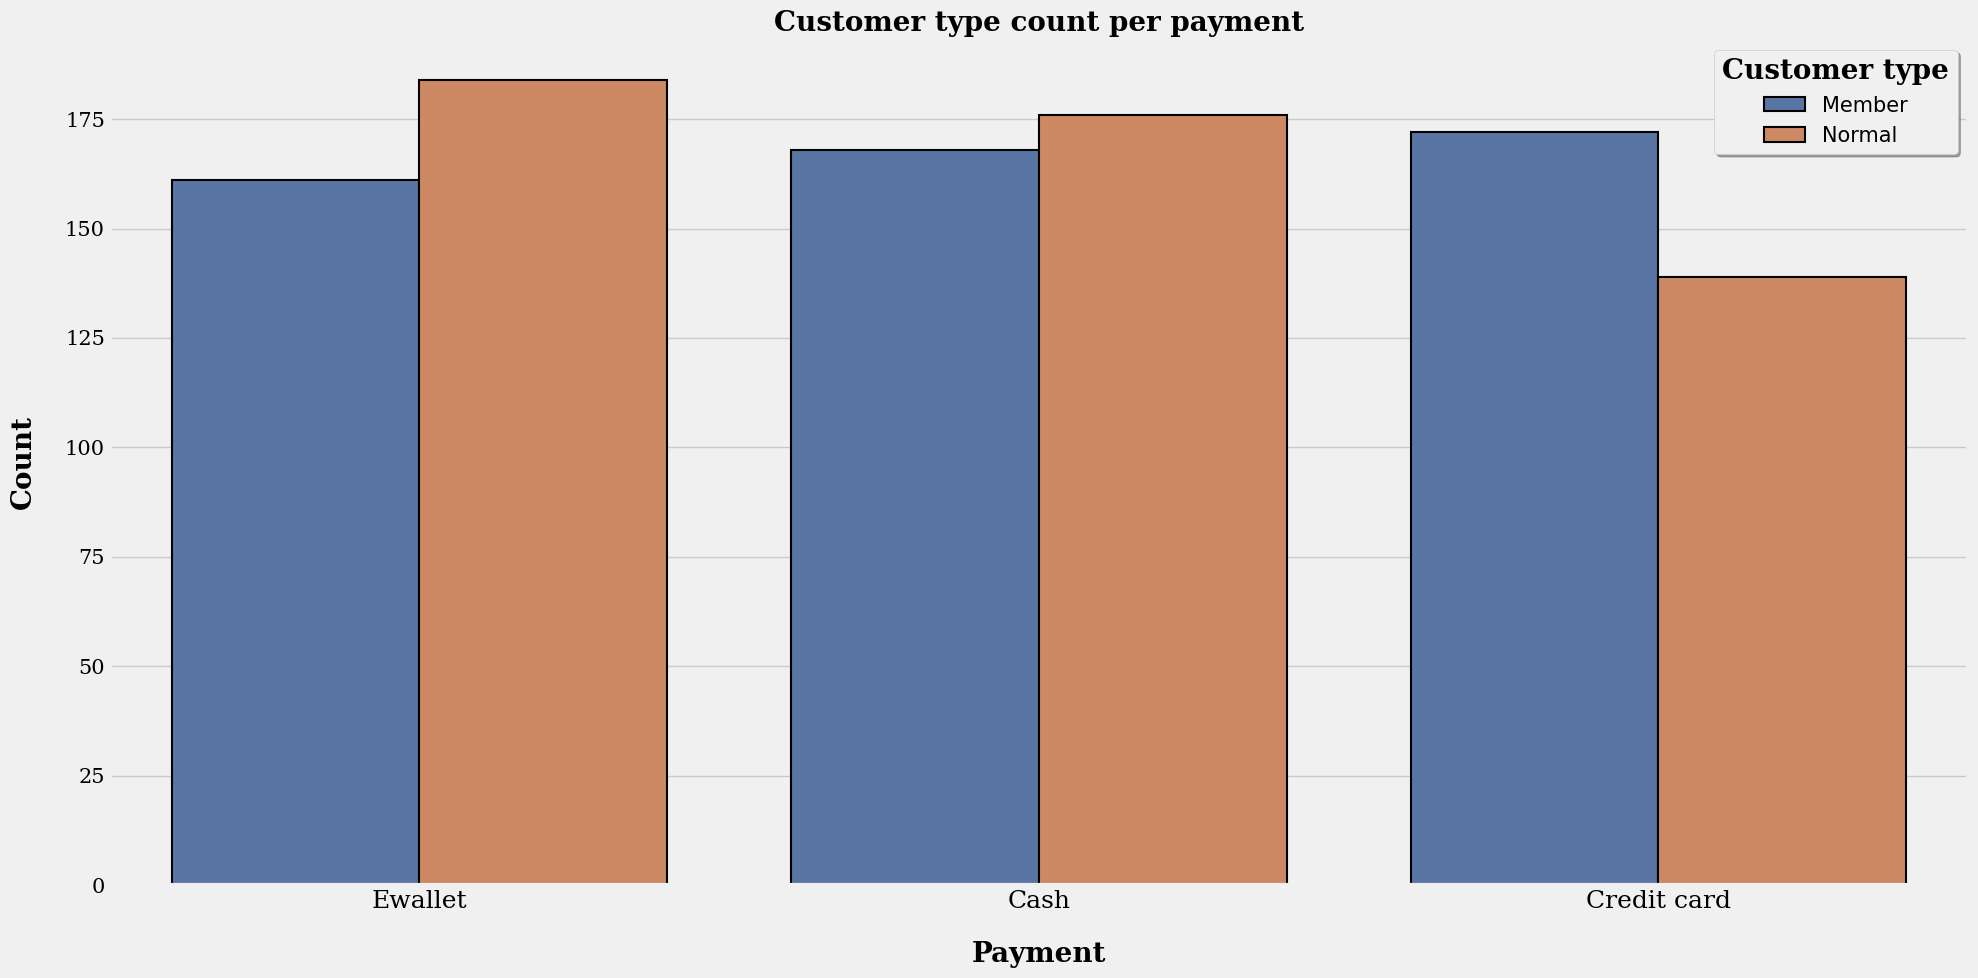

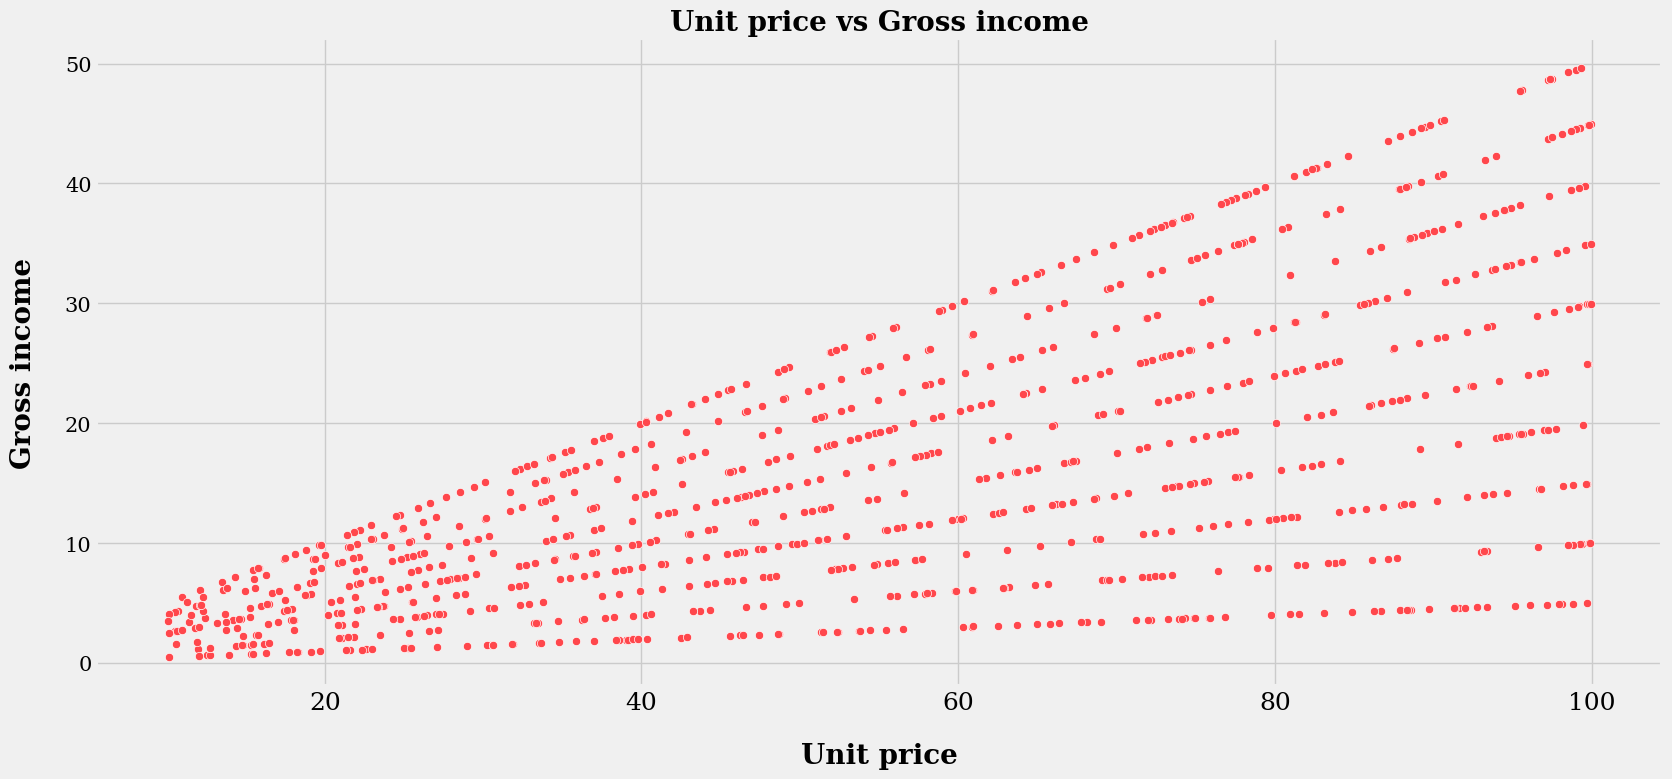

In [ ]:
plt.figure(figsize=(20, 10))
sns.countplot(x = 'Payment', data = df, palette = palette,
              hue='Customer type', lw=1.5, edgecolor='black')

setup_graph_legend('Customer type', 'Payment', 'Count', 'Customer type count per payment')

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 8))

sns.scatterplot(x = 'Unit price', y = 'gross income', data = df, color = 'xkcd:light red')

setup_graph('Unit price', 'Gross income', 'Unit price vs Gross income')